# HW3: Dataset Overview and Use Case Examples
## EDS 220, Fall 2021

## Informing Oil Spill Impacts with High Frequency Radar Surface Current Data
### U.S. West Coast, 6km, hourly

### Authors
- Elmera Azadpour, UC Santa Barbara, 2nd Year MESM
- Ian Brunjes, UC Santa Barbara, 2nd Year MESM
- Phillip Puettmann, UC Santa Barbara, 2nd Year Information Systems (Germany)
- Quin Smith, UC Santa Barbara, 2nd Year MESM

## Table of Contents

[1. Purpose](#purpose)

[2. Dataset Description](#overview)

[3. Data I/O](#io)

[4. Metadata Display and Basic Visualization](#display)

[5. Use Case Examples](#usecases)

[6. Create Binder Environment](#binder)

[7. References](#references)

<a id='purpose'></a> 
### Notebook Purpose

The purpose of this notebook is to provide an introduction to using high frequency radar data from the Integrated Ocean Observing System network to derive surface current velocity and direction in the Huntington Beach area during the recent oil spill.

HF radar data are land-based radar systems that use radio waves to measure the speed and direction of ocean surface currents in near real-time. These radar systems can measure the top 1-2 meter of water column from a range of 200 km away from shore. There is a network of 62 HF radars that contribute to the regional data for the California coast, with resolutions ranging from 500 m to 6 km depending on radar frequency. Specifically, this notebook will explore 6 km resolution (hourly) high frequency (HF) radar data of surface currents from the Scripps Institute of Oceanography, UCSD for analysis of the 2021 oil spill off the coast of Huntington Beach, CA.

<a id='overview'></a> 
### Dataset Description

This dataset was created by the Coastal Observing Research and Development Center at Scripps Institution of Oceanography, UCSD. The [ HF radar Thredds data server](https://hfrnet-tds.ucsd.edu/thredds/catalog.html) contains real-time velocity (RTV) measurements across the Gulf of Alaska, US East and Gulf Coast, Hawai'i, Puerto Rico and Virgin Islands, and US West Coast. The server contains data across hourly, 25hr average, monthly average and annual average RTV. For our purposes, we will download US West Coast 6 km resolution, hourly data in netCDF format. To retrieve this data, we have pulled from the Thredds server using OPeNDAP and xarray.

Upon early data exploration, we noticed the 6 km hourly data does not have complete coverage across the time series and contains spatial incompleteness (NaNs). However, the dataset contains metadata with information regarding data format (datetime64) and geospatial coordinate information (WGS84, Degrees N & E). For our analysis, we have focused on the time frame October 4th, 2021 - October 7th, 2021 to analyze RTV measurements from the recent oil spill off the coast of Huntington Beach, CA.

Later on, we want to add the actual oil blob movements over time to the plot. We are retrieving this data from a different data source. The data is available from the [Environmental Response Management Application (ERMA)](https://erma.noaa.gov/southwest), which is a web-based Geographic Information System (GIS) tool that assists in dealing with incidents that may adversely impact the environment. ERMA is a project by the NOAA Office of Response and Restauration. Within ERMA, multiple reports are accessible. We want to focus on the NESDIS Marine Pollution Surveillance Reports, which cover data for multiple critical events such as the Huntington Beach spill earlier this year. The data decribes the suspected oil locations and coverages. These results are compiled from satellite data provided by the Copernicus Sentinel mission. Data are either available as images with complete descriptions and annotations, as a layer for an interactive map or available for download. You can see an example of the first one below.
For further processing in our project, we chose to download the data from the website and extracted the relevant shapefiles (*.shp, *.shx and *.dbf files) to the \"shp\" subfolder.

![Example Sentinel Satellite Imagery with suspected oil annotations](https://prod-erma-api.orr.noaa.gov/api/v1/data_layer_file/12964/download/)
Fig. 1: Example Sentinel Satellite Imagery with suspected oil annotations
Source: https://prod-erma-api.orr.noaa.gov/api/v1/data_layer_file/12964/download/



<a id='io'></a> 
### Dataset Input/Output 

Here, we provide code to read in the data.

1) Import necessary packages

2) Set the data import parameters and import the data!:
- set variable names to store imported data, 'lazy' import using `xr.open_dataset()`
- filter over temporal range and region of interest
- store time-series of the data to be used later
- store size of array


In [ ]:
#load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import contextily as ctx
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation

In [ ]:
# Using thredds server url and xarray, read in the dataset
ds6km_hr = xr.open_dataset('http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd')

In [ ]:
# Filtering data to ROI
# bbox: -118.432617,33.069679,-117.386169,33.779147

x1, y1, x2, y2 = (-119.413147,32.858825,-117.215881,34.064037)
ds_hb_spill = ds6km_hr.sel(
    time=slice("2021-10-04", "2021-10-07"),
    lon=slice(x1, x2),
    lat=slice(y1, y2),
    nv=0,
    time_1=0
)

# Store times in array for later
times = ds_hb_spill.time.to_series()

In [ ]:
# Get dimensions of array
ds_hb_spill.sizes

Frozen({'lat': 22, 'lon': 35, 'time': 96})

<a id='display'></a> 
### Metadata Display and Basic Visualization

Next, let's look at the variables and metadata for our HF data. The netCDF data is stored as an xarray object, which we can read by calling the object's variable name.

In [ ]:
ds_hb_spill

<xarray.Dataset>
Dimensions:                (lat: 22, lon: 35, time: 96)
Coordinates:
  * lat                    (lat) float32 32.89 32.95 33.0 ... 33.92 33.97 34.03
  * lon                    (lon) float32 -119.4 -119.3 -119.2 ... -117.3 -117.2
  * time                   (time) datetime64[ns] 2021-10-04 ... 2021-10-07T23...
    time_run               (time) datetime64[ns] ...
Data variables: (12/14)
    time_bnds              int32 ...
    depth_bnds             float32 ...
    wgs84                  int8 ...
    processing_parameters  int8 ...
    radial_metadata        int8 ...
    depth                  float32 ...
    ...                     ...
    v                      (time, lat, lon) float32 ...
    dopx                   (time, lat, lon) float32 ...
    dopy                   (time, lat, lon) float32 ...
    hdop                   (time, lat, lon) float32 ...
    number_of_sites        (time, lat, lon) float32 ...
    number_of_radials      (time, lat, lon) float32 ...
Attributes: (12/31)
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202111190300siohfruwlsrtvuswc6km
    date_created:              2021-11-19T04:52:56Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. We...
    ...                        ...
    format_version:            1.1.00
    product_version:           2.0.00
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_West_Coast_6km_Resolutio...

The data contains 14 variables:
- time_bnds
- depth_bnds
- wgs84
- processing_parameters
- radial_metadata
- depth
- time_offset
- u
- v
- dopx
- dopy
- hdop
- number_of_sites
- number_of_radials

For our analysis, we are most interested in the vector components (u and v), which will be used to derive velocity and direction of sea surface currents. However, the other variables are also important and worthwhile to explore at a later date. For example, dopx, dopy, and hdop are all measures of "dilution of precision", basically uncertainty associated with the vector component values. 

Additionally, metadata is stored for the data under the 'Attributes' tab of the output.  These include:

- Conventions
- id
- date_created
- source
- program
- title
- summary
- instrument
- keywords
- geospatial_lat_min
- geospatial_lat_max
- geospatial_lon_min
- geospatial_lon_max
- processing_level
- history
- references
- institution
- creator_type
- creator_name
- creator_email
- creator_url
- naming_authority
- standard_name_vocabulary
- keywords_vocabulary
- instrument_vocabulary
- format_version
- product_version 
- _CoordSysBuilder
- cdm_data_type
- featureType
- location

These metadata very helpful in describing the dataset and attributing credit to the various creators and organizations involved. They can be viewed and explored in the above output. But now let's create a preliminary visualization over an arbitrary coordinate to check for obvious data gaps. We'll use lucky number 13 to index both latitude and longitude.

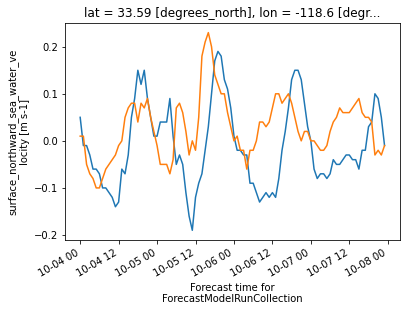

In [ ]:
# Plot u & v for a valid coordinate over timespan to check data gaps
single_coord = ds_hb_spill.isel(lat=13, lon=13)
single_coord.u.plot()
single_coord.v.plot()

Our preliminary glance at the data looks pretty good!

<a id='usecases'></a> 
### Use Case Examples

This is the "meat" of the notebook, and what will take the majority of the time to present in class. This section should provide:
1) A plain-text summary (1-2 paragraphs) of the use case example you have chosen: include the target users and audience, and potential applicability. For example, the Week 7 SST exercise might discuss how the state of the ENSO system can be important for seasonal weather forecasts/coral bleaching outlooks, then mention the typical diagnostics associated with ENSO (i.e. identification of El Nino/La Nina events).

2) Markdown and code blocks demonstrating how one walks through the desired use case example. This should be similar to the labs we've done in class: you might want to demonstrate how to isolate a particularly interesting time period, then create an image showing a feature you're interested in, for example.

3) A discussion of the results and how they might be extended on further analysis. For example, we are doing El Nino/La Nina composites in class; a natural extension might be to look at individual events to see what their particular impacts were. Or if there are data quality issues which impact the results, you could discuss how these might be mitigated with additional information/analysis.

Just keep in mind, you'll have roughly 20 minutes for your full presentation, and that goes surprisingly quickly! Probably 2-3 diagnostics is the most you'll be able to get through (you could try practicing with your group members to get a sense of timing).


In [ ]:
# Cast 3 dimensional array to dataframe
df = ds_hb_spill.to_dataframe().reset_index()

# Remove rows with NaN
df = df[-df.isna().any(axis=1)]
df

,lat,lon,time,time_run,time_bnds,depth_bnds,wgs84,processing_parameters,radial_metadata,depth,time_offset,u,v,dopx,dopy,hdop,number_of_sites,number_of_radials
488,32.893059,-119.053764,2021-10-04 08:00:00,2021-10-04 08:00:00,1637112600,0.0,-127,-127,-127,1.4,2012-01-01,-0.18,-0.20,0.42,1.17,1.24,3.0,15.0
489,32.893059,-119.053764,2021-10-04 09:00:00,2021-10-04 09:00:00,1637112600,0.0,-127,-127,-127,1.4,2012-01-01,-0.15,0.02,0.41,1.17,1.24,3.0,17.0
495,32.893059,-119.053764,2021-10-04 15:00:00,2021-10-04 15:00:00,1637112600,0.0,-127,-127,-127,1.4,2012-01-01,0.03,0.35,0.39,1.13,1.19,3.0,16.0
496,32.893059,-119.053764,2021-10-04 16:00:00,2021-10-04 16:00:00,1637112600,0.0,-127,-127,-127,1.4,2012-01-01,0.06,0.30,0.38,1.15,1.21,3.0,15.0
500,32.893059,-119.053764,2021-10-04 20:00:00,2021-10-04 20:00:00,1637112600,0.0,-127,-127,-127,1.4,2012-01-01,0.02,-0.19,0.38,1.12,1.19,3.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71899,34.025799,-118.554039,2021-10-07 19:00:00,2021-10-07 19:00:00,1637112600,0.0,-127,-127,-127,1.4,2012-01-01,0.11,0.00,0.08,0.14,0.17,4.0,385.0
71900,34.025799,-118.554039,2021-10-07 20:00:00,2021-10-07 20:00:00,1637112600,0.0,-127,-127,-127,1.4,2012-01-01,0.12,-0.03,0.09,0.14,0.17,4.0,377.0
71901,34.025799,-118.554039,2021-10-07 21:00:00,2021-10-07 21:00:00,1637112600,0.0,-127,-127,-127,1.4,2012-01-01,0.15,-0.01,0.09,0.15,0.17,6.0,359.0
71902,34.025799,-118.554039,2021-10-07 22:00:00,2021-10-07 22:00:00,1637112600,0.0,-127,-127,-127,1.4,2012-01-01,0.15,0.00,0.09,0.15,0.18,5.0,380.0


In [ ]:
# Build a geodataframe using lat lon for geometries
geo_df = gpd.GeoDataFrame(
    df, 
    geometry = gpd.points_from_xy(df['lon'], df['lat']), 
    crs = 4326
)

C:\Users\ianbr\miniconda3\envs\gee\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [ ]:
# Get magnitude of vectors
geo_df['magnitude'] = np.sqrt(geo_df['u']**2 + geo_df['v']**2)

# Create normalized vectors for plotting
geo_df['u_norm'] = geo_df['u'] / geo_df['magnitude']
geo_df['v_norm'] = geo_df['v'] / geo_df['magnitude']

In [ ]:
# Set color values based on magnitude
colors = geo_df['magnitude']

# Create a color scale that aligns with range of magnitude values
norm = Normalize()
norm.autoscale(colors) # normalizes the range of magnitudes between 0-1

# Set color palette
colormap = cm.plasma

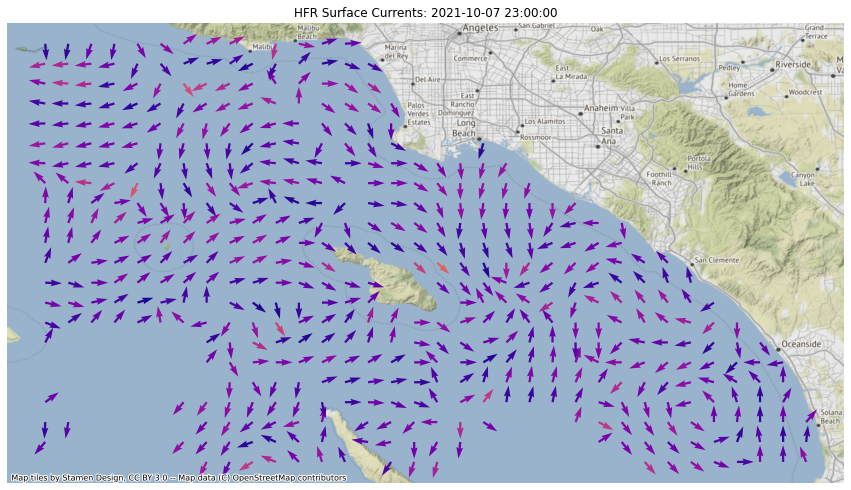

In [ ]:
# Choose which time index to plot
t = 95
geo_df0 = geo_df[geo_df['time'] == times[t]]

# Set up plot
fig, ax = plt.subplots(figsize=(15,15))

# Build quivers
ax.quiver(geo_df0['geometry'].x, 
          geo_df0['geometry'].y, 
          geo_df0['u_norm'], 
          geo_df0['v_norm'],
          color=colormap(norm(colors)), # sets color based on magnitude color scale
          scale = 50 # scale can be set to change the default arrow size, but seems inconsistent
         )

# Add basemap
ctx.add_basemap(ax, crs=geo_df0.crs.to_string(), source=ctx.providers.Stamen.Terrain)

ax.set_axis_off()
ax.set_title('HFR Surface Currents: ' + str(times[t]))
plt.show()

<IPython.core.display.Javascript object>


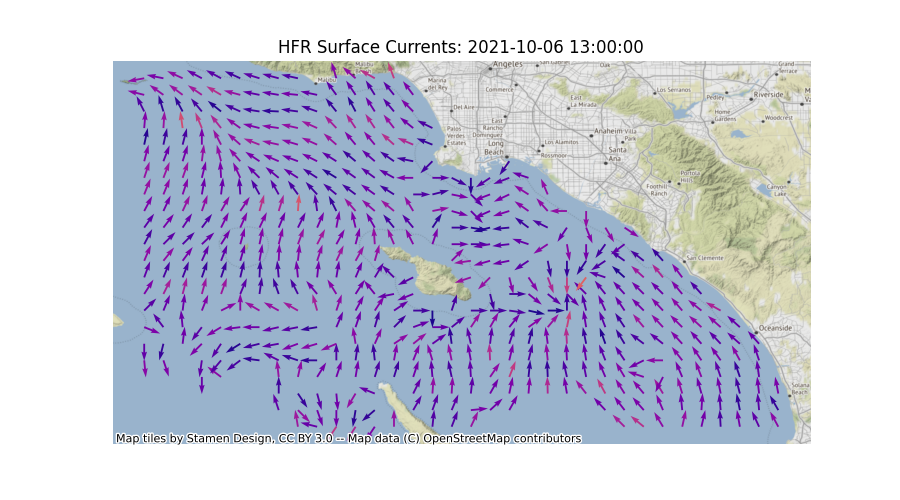

In [ ]:
# Animation testing
# inline plots for jupyter notebook don't support animation, need to switch plot output to use notebook backend
%matplotlib notebook

# Provision plot at time 0 (same as above)
t = 0
geo_df0 = geo_df[geo_df['time'] == times[t]]

fig, ax = plt.subplots(figsize=(9,5))

ax.quiver(geo_df0['geometry'].x, 
          geo_df0['geometry'].y, 
          geo_df0['u_norm'], 
          geo_df0['v_norm'],
          color=colormap(norm(colors)), # sets color based on magnitude color scale
          scale = 50 # scale can be set to change the default arrow size, but seems inconsistent
         )

ctx.add_basemap(ax, crs=geo_df0.crs.to_string(), source=ctx.providers.Stamen.Terrain)
ax.set_axis_off()
ax.set_title('HFR Surface Currents: ' + str(times[t]))

def updatePlot(num):
    current = geo_df[geo_df['time'] == times[num]]
    ax.clear() # need to clear previously rendered quivers.. also clears basemap/axis settings
    # There is a way to update quivers rather than remove and add new ones.. worth exploring
    ax.quiver(current['geometry'].x, 
          current['geometry'].y, 
          current['u_norm'], 
          current['v_norm'],
          color=colormap(norm(colors)), # sets color based on magnitude color scale
         )
    ax.set_title('HFR Surface Currents: ' + str(times[num]))
    ctx.add_basemap(ax, crs=geo_df0.crs.to_string(), source=ctx.providers.Stamen.Terrain) # need to readd basemap.. very slow
    ax.set_axis_off()

# Call animation function, number of frames = number of indexes in our timespan
ani = FuncAnimation(fig, updatePlot, interval=200,
                              frames=times.size, repeat=True)
#fig.tight_layout()
plt.show()

<a id='binder'></a> 
### Create Binder Environment

TODO:

The last step is to create a Binder environment for your project, so that we don't have to spend time configuring everyone's environment each time we switch between group presentations. Instructions are below:

 - Assemble all of the data needed in your Github repo: Jupyter notebooks, a README file, and any datasets needed (these should be small, if included within the repo). Larger datasets should be stored on a separate server, and access codes included within the Jupyter notebook as discussed above. 
 
 - Create an _environment_ file: this is a text file which contains information on the packages needed in order to execute your code. The filename should be "environment.yml": an example that you can use for the proper syntax is included in this template repo. To determine which packages to include, you'll probably want to start by displaying the packages loaded in your environment: you can use the command `conda list -n [environment_name]` to get a list.
 
 More information on environment files can be found here:
 https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#

 - Create Binder. Use http://mybinder.org to create a  URL for your notebook Binder (you will need to enter your GitHub repo URL). You can also add a Launch Binder button directly to your GitHub repo, by including the following in your README.md:

```
launch with myBinder
[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/<path to your repo>)
```

<a id='references'></a> 
### References

List relevant references. Here are some additional resources on creating professional, shareable notebooks you may find useful:

1. https://math.libretexts.org/Bookshelves/Precalculus/Precalculus_(OpenStax)/08%3A_Further_Applications_of_Trigonometry/8.08%3A_Vectors
2. https://erma.noaa.gov/southwest#/layers=1+48526+48525+48506+48569+48575+48462+48452+48423&x=-118.12634&y=33.47098&z=9.6&panel=layer
3. https://sccoos.org/high-frequency-radar/
4. Thredds server with HF Radar Measurements: https://hfrnet-tds.ucsd.edu/thredds/catalog.html
5. Integrated Ocean Observing System, About HF Radar: https://ioos.noaa.gov/project/hf-radar/
6. Coastal HF radars in the Mid-Atlantic Bight: http://www.codar.com/images/about/2012_Kohut_OceanDynamics.pdf